I noticed that intraday forex patterns need to be mean reverting, especially after what happens between 8:00 am and 14:00. I would like to backtest a simple strategy:

1 - First, we analyze the rally between 08:00 and 14:00. If it is a clear trend upward or downward, we take an opposite position at 14:01. We then exit the market as soon as we meet our take profit or stop loss rule.
2 - There are multiple ways to identify if a rally is trend upward or downward, we'll try different setups:
a) By checking the distribution of historical returns between 08:00 and 14:00, a trend will be anything belonging in the tail of the distribution (we will try different threshold of nb of std deviations)
b) By checking if the rally between 08:00 and 14:00 is significantly over the preceding average between 00:00 and 7:59
c) By checking the volume 

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

df = pd.read_csv('/root/QuantAndCo/Data/forex/EUR_USD/1m/OHLC/2019-07-19 13:31:16_2024-04-19 16:11:16.csv')
df.close_time = pd.to_datetime(df.close_time)
df.set_index('close_time', inplace=True)

In [8]:
def calculate_periodic_returns(df, start_time, end_time):
    df = df.copy()

    start_prices = df.at_time(start_time)
    end_prices = df.at_time(end_time)

    start_prices['date'] = start_prices.index.normalize().date
    end_prices['date'] = end_prices.index.normalize().date

    start_prices.set_index('date', inplace=True)
    end_prices.set_index('date', inplace=True)


    comb_df = pd.merge(start_prices, end_prices, left_index=True, right_index=True, suffixes=('_start', '_end'))

    return comb_df


def plot_histogram(df, start_time, end_time, column="Close"):

    returns = df[f"{column}_end"] / df[f"{column}_start"] - 1

    start_date, end_date = df.index[0], df.index[-1]

    mean_returns = returns.mean()
    std_returns = returns.std()

    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=50, alpha=0.75, color='blue')
    plt.title(f'Histogram of Intraday Returns between {start_time} and {end_time} \n {start_date} to {end_date}')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    
    # Standard deviation lines
    for i in range(1, 4):
        plt.axvline(x=mean_returns + i*std_returns, color='r', linestyle='dashed', linewidth=1, label=f'Mean + {i} STD')
        plt.axvline(x=mean_returns - i*std_returns, color='g', linestyle='dashed', linewidth=1, label=f'Mean - {i} STD')

    plt.grid(True)
    plt.legend()
    plt.show()

    return mean_returns, std_returns


def MeanReversionIntraday(df, start_time, end_time, 
                          last_train_date, price_column, long_thres, short_thres):
    train_df = df.loc[df.index<=last_train_date]
    comb_train = calculate_periodic_returns(train_df, start_time, end_time)
    mu, sigma = plot_histogram(comb_train, start_time, end_time, price_column)
    test_df_init = df.loc[df.index > last_train_date]

    comb_test = calculate_periodic_returns(test_df_init, start_time, end_time)

    end_test_time = datetime.strptime(end_time, '%H:%M') + timedelta(minutes=1)
    str_test_time = end_test_time.strftime('%H:%M')

    test_df = test_df_init.between_time(str_test_time, '23:59')

    test_df['date'] = test_df.index.normalize().date
    test_df.date = pd.to_datetime(test_df.date)
    comb_test[f"{start_time[:2]}-{end_time[:2]}_return"] = (comb_test[f"{price_column}_end"] - comb_test[f"{price_column}_start"]) / comb_test[f"{price_column}_start"]
    test_returns = comb_test[[f"{start_time[:2]}-{end_time[:2]}_return"]]
    test_returns.index = pd.to_datetime(test_returns.index)

    test_df.reset_index(inplace=True)
    test_df.set_index('date', inplace=True)
    test_df.index = pd.to_datetime(test_df.index)


    test_df = test_df[["close_time", "Close"]]

    test_df = pd.merge(test_df, test_returns, right_index=True, left_index=True, how='left')

    test_df["signal"] = (test_df[f"{start_time[:2]}-{end_time[:2]}_return"] <= mu + long_thres * sigma) * 1 + (test_df[f"{start_time[:2]}-{end_time[:2]}_return"] >= mu + short_thres * sigma) * -1

    test_df = pd.merge(test_df_init, test_df.set_index('close_time').drop(columns="Close"), right_index=True, left_index=True, how='left')
    test_df["signal"].ffill(inplace=True)
    test_df[f"{start_time[:2]}-{end_time[:2]}_return"].ffill(inplace=True)

    test_df["timestamp"] = pd.to_datetime(test_df.index)
    previous_hour = str(int(end_time[:2]) - 1) + ':59'
    filtered_df = test_df[(test_df["timestamp"].dt.time >= pd.to_datetime('00:00').time()) & (test_df["timestamp"].dt.time <= pd.to_datetime(end_time).time())]

    test_df.loc[filtered_df.index, "signal"] = 0 #always exit the position at the end of the day and can only re-start after end_time
    
    return test_df

In [9]:
def vectorized_backtesting(df, leverage, fees, initial_wealth=10_000, price_column='Close',
                           stop_loss=-1, take_profit=1):

    import numpy as np

    # Avoid look-ahead bias by shifting the signal forward by one period
    # Signals effectively become actionable the next bar
    df['signal'] = df['signal'].shift(1).fillna(0)

    df['position'] = df['signal'] * leverage

    # Calculate daily returns for each asset
    df["return"] = df[price_column].pct_change().fillna(0)

    df["net_position_change"] = df['position'].diff().abs()

    # Calculate portfolio changes from returns
    df['portfolio_change'] = df[f'position'] * df['return']

    # Determine positions where we go from 0 to 1 or -1
    df['new_position'] = (df['position'] != 0) & (df['position'].shift(1) == 0)

    # Set the entry price only when 'new_position' is True
    df['entry_price'] = df.apply(lambda row: row[price_column] if row['new_position'] else np.nan, axis=1)

    # Forward fill the entry prices to apply them until the position changes
    df['entry_price'].ffill(inplace=True)

    # Calculate unrealized pnl
    df['unrealized_pnl'] = df["position"] * ( (df[price_column] - df['entry_price']) / df['entry_price'] )

    df['stop_triggered'] = ((df['unrealized_pnl'] <= stop_loss) | (df['unrealized_pnl'] >= take_profit)).shift(1).fillna(False)

    df['position'] = df.apply(lambda row: 0 if row['stop_triggered'] else row['position'], axis=1)

    df['net_position_change'] = df['position'].diff().abs()
    df['portfolio_change'] = df['position'] * df['return']

    # Calculate cumulative wealth starting from initial_wealth
    df['Wealth'] = (1+df['portfolio_change'] - fees * df["net_position_change"]).cumprod().shift(1) * initial_wealth
    df["fees"] = fees * df["Wealth"].shift(1) * df["net_position_change"].shift(1)

    

    return df

/tmp/ipykernel_1157724/2462928926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_prices['date'] = start_prices.index.normalize().date
/tmp/ipykernel_1157724/2462928926.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_prices['date'] = end_prices.index.normalize().date


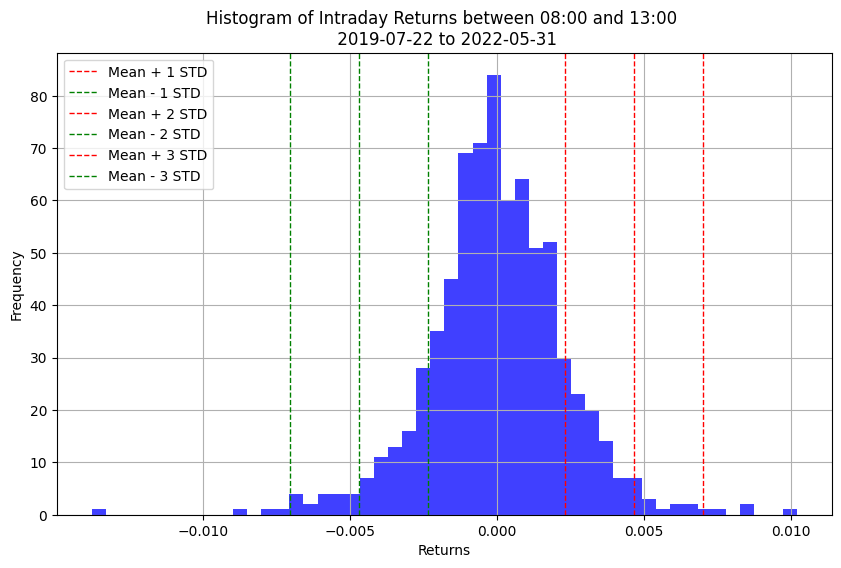

/tmp/ipykernel_1157724/2462928926.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_prices['date'] = start_prices.index.normalize().date
/tmp/ipykernel_1157724/2462928926.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_prices['date'] = end_prices.index.normalize().date
/tmp/ipykernel_1157724/2462928926.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [10]:
signal_df = MeanReversionIntraday(df, start_time='08:00', end_time='13:00', 
                                  last_train_date='2022-06-01', price_column="Close", 
                                  long_thres=-1, short_thres=1)

In [11]:
#stop dans le temps -> tous les jours 


In [12]:
#Value at Risk & Max Drawdown
#size betting -> levier proportionnel au z-score pour le pair trading

#>= 15%/mois avec - fréquence de drawdown > 10%


<Axes: xlabel='close_time'>

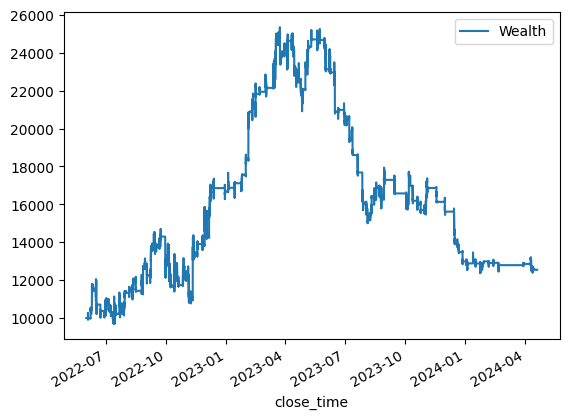

In [13]:
bt = vectorized_backtesting(signal_df, leverage=10, fees=0.00007)
bt[["Wealth"]].plot()

In [16]:
bt.loc[bt.net_position_change!=0].head(30)

,Open,High,Low,Close,Volume,08-13_return,signal,timestamp,position,return,net_position_change,portfolio_change,new_position,entry_price,unrealized_pnl,stop_triggered,Wealth,fees
close_time,,,,,,,,,,,,,,,,,,
2022-06-01 00:01:00+00:00,1.07334,1.07342,1.07329,1.07342,80.0,NaN,0.0,2022-06-01 00:01:00+00:00,0.0,0.000000,NaN,0.000000,False,NaN,NaN,False,NaN,NaN
2022-06-03 13:02:00+00:00,1.07198,1.07228,1.07198,1.07222,155.0,-0.003672,1.0,2022-06-03 13:02:00+00:00,10.0,0.000224,10.0,0.002239,True,1.07222,0.0,False,10000.000000,0.0
2022-06-05 21:05:00+00:00,1.07221,1.07222,1.07212,1.07212,6.0,-0.003672,0.0,2022-06-05 21:05:00+00:00,0.0,-0.000047,10.0,-0.000000,False,1.07222,-0.0,False,10007.085828,0.0
2022-06-07 13:02:00+00:00,1.06554,1.06560,1.06540,1.06546,132.0,-0.002920,1.0,2022-06-07 13:02:00+00:00,10.0,-0.000056,10.0,-0.000563,True,1.06546,0.0,False,10000.080868,0.0
2022-06-08 00:01:00+00:00,1.06984,1.07012,1.06981,1.06988,156.0,-0.002920,0.0,2022-06-08 00:01:00+00:00,0.0,0.000047,10.0,0.000000,False,1.06546,0.0,False,10400.365389,0.0
2022-06-08 13:02:00+00:00,1.07294,1.07318,1.07290,1.07314,158.0,0.004005,-1.0,2022-06-08 13:02:00+00:00,-10.0,0.000186,10.0,-0.001864,True,1.07314,-0.0,False,10393.085133,0.0
2022-06-09 00:01:00+00:00,1.07165,1.07166,1.07142,1.07145,95.0,0.004005,0.0,2022-06-09 00:01:00+00:00,0.0,-0.000177,10.0,-0.000000,False,1.07314,-0.0,False,10507.523069,0.0
2022-06-09 13:02:00+00:00,1.07381,1.07400,1.07330,1.07359,578.0,0.004150,-1.0,2022-06-09 13:02:00+00:00,-10.0,-0.000233,10.0,0.002328,True,1.07359,-0.0,False,10500.167803,0.0
2022-06-10 00:01:00+00:00,1.06174,1.06176,1.06134,1.06137,117.0,0.004150,0.0,2022-06-10 00:01:00+00:00,0.0,-0.000358,10.0,-0.000000,False,1.07359,-0.0,False,11735.513214,0.0


In [34]:
bt.loc[bt.index>='2022-06-06 14:00'][["timestamp", "Close", "signal", "position", "portfolio_change", "fees", "Wealth"]].head(30)

,timestamp,Close,signal,position,portfolio_change,fees,Wealth
close_time,,,,,,,
2022-06-06 14:00:00+00:00,2022-06-06 14:00:00+00:00,1.07178,0.0,0.0,0.000000,0.000000,10000.000000
2022-06-06 15:00:00+00:00,2022-06-06 15:00:00+00:00,1.06976,1.0,10.0,-0.018847,0.000000,10000.000000
2022-06-06 16:00:00+00:00,2022-06-06 16:00:00+00:00,1.07006,1.0,10.0,0.002804,7.000000,9804.528485
2022-06-06 17:00:00+00:00,2022-06-06 17:00:00+00:00,1.06986,1.0,10.0,-0.001869,0.000000,9832.023985
2022-06-06 18:00:00+00:00,2022-06-06 18:00:00+00:00,1.06907,1.0,10.0,-0.007384,0.000000,9813.647400
2022-06-06 19:00:00+00:00,2022-06-06 19:00:00+00:00,1.06956,1.0,10.0,0.004583,0.000000,9741.182017
2022-06-06 20:00:00+00:00,2022-06-06 20:00:00+00:00,1.06958,1.0,10.0,0.000187,0.000000,9785.829975
2022-06-06 21:00:00+00:00,2022-06-06 21:00:00+00:00,1.06956,1.0,10.0,-0.000187,0.000000,9787.659854
2022-06-06 22:00:00+00:00,2022-06-06 22:00:00+00:00,1.06944,1.0,10.0,-0.001122,0.000000,9785.829667


/tmp/ipykernel_1032565/2248590751.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_prices['date'] = start_prices.index.normalize().date
/tmp/ipykernel_1032565/2248590751.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_prices['date'] = end_prices.index.normalize().date


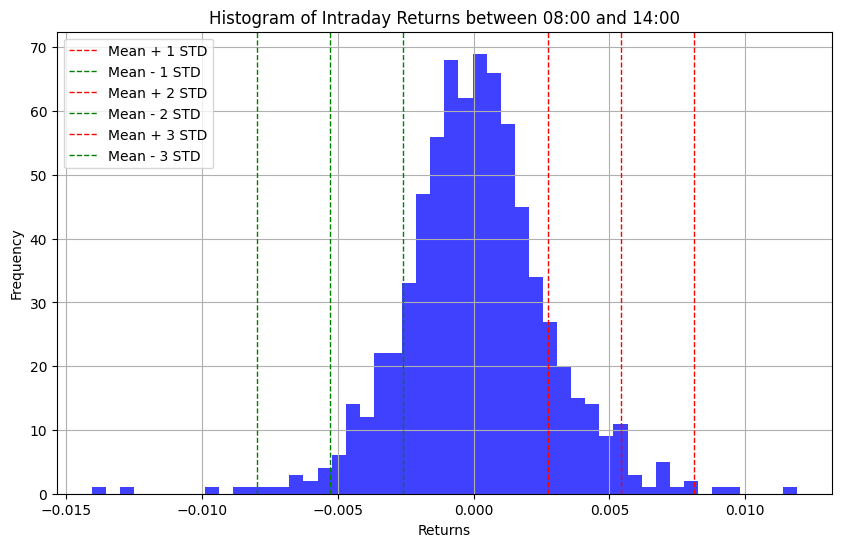

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('/root/QuantAndCo/Data/forex/EUR_USD/1m/OHLC/2019-07-19 13:31:16_2024-04-19 16:11:16.csv')
df.close_time = pd.to_datetime(df.close_time)
df.set_index('close_time', inplace=True)

last_train_date = '2022-06-01'

train_df = df.loc[df.index<=last_train_date]

def calculate_periodic_returns(df, start_time, end_time):
    df = df.copy()

    start_prices = df.at_time(start_time)
    end_prices = df.at_time(end_time)

    start_prices['date'] = start_prices.index.normalize().date
    end_prices['date'] = end_prices.index.normalize().date

    start_prices.set_index('date', inplace=True)
    end_prices.set_index('date', inplace=True)


    comb_df = pd.merge(start_prices, end_prices, left_index=True, right_index=True, suffixes=('_start', '_end'))

    return comb_df


comb_train = calculate_periodic_returns(train_df, '08:00', '14:00')


def plot_histogram(df, column="Close"):

    returns = df[f"{column}_end"] / df[f"{column}_start"] - 1

    mean_returns = returns.mean()
    std_returns = returns.std()

    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=50, alpha=0.75, color='blue')
    plt.title(f'Histogram of Intraday Returns between 08:00 and 14:00')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    
    # Standard deviation lines
    for i in range(1, 4):
        plt.axvline(x=mean_returns + i*std_returns, color='r', linestyle='dashed', linewidth=1, label=f'Mean + {i} STD')
        plt.axvline(x=mean_returns - i*std_returns, color='g', linestyle='dashed', linewidth=1, label=f'Mean - {i} STD')

    plt.grid(True)
    plt.legend()
    plt.show()

    return mean_returns, std_returns

mu, sigma = plot_histogram(comb_train, 'Close')

In [13]:
def vectorized_backtesting(df, leverage, fees, initial_wealth=10_000, price_column='Close',
                           stop_loss=-1, take_profit=1):

    import numpy as np

    # Avoid look-ahead bias by shifting the signal forward by one period
    # Signals effectively become actionable the next bar
    df['signal'] = df['signal'].shift(1).fillna(0)

    df['position'] = df['signal'] * leverage

    # Calculate daily returns for each asset
    df["return"] = df[price_column].pct_change().fillna(0)

    df["net_position_change"] = df['position'].diff().abs()

    # Calculate portfolio changes from returns
    df['portfolio_change'] = df[f'position'] * df['return']

    # Determine positions where we go from 0 to 1 or -1
    df['new_position'] = (df['position'] != 0) & (df['position'].shift(1) == 0)

    # Set the entry price only when 'new_position' is True
    df['entry_price'] = df.apply(lambda row: row[price_column] if row['new_position'] else np.nan, axis=1)

    # Forward fill the entry prices to apply them until the position changes
    df['entry_price'].ffill(inplace=True)

    # Calculate unrealized pnl
    df['unrealized_pnl'] = df["position"] * ( (df[price_column] - df['entry_price']) / df['entry_price'] )

    df['stop_triggered'] = ((df['unrealized_pnl'] <= stop_loss) | (df['unrealized_pnl'] >= take_profit)).shift(1).fillna(False)

    df['position'] = df.apply(lambda row: 0 if row['stop_triggered'] else row['position'], axis=1)

    df['net_position_change'] = df['position'].diff().abs()
    df['portfolio_change'] = df['position'] * df['return']

    # Calculate cumulative wealth starting from initial_wealth
    df['Wealth'] = (1+df['portfolio_change'] - fees * df["net_position_change"]).cumprod().shift(1) * initial_wealth
    df["fees"] = fees * df["Wealth"].shift(1) * df["net_position_change"].shift(1)

    return df


In [15]:
last_train_date='2022-06-01'

test_df = df.loc[df.index > last_train_date]

comb_test = calculate_periodic_returns(test_df, '08:00', '14:00')

test_df = test_df.between_time('14:01', '23:59')

/tmp/ipykernel_1034105/4142317070.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_prices['date'] = start_prices.index.normalize().date
/tmp/ipykernel_1034105/4142317070.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_prices['date'] = end_prices.index.normalize().date


In [16]:
test_df['date'] = test_df.index.normalize().date
test_df.date = pd.to_datetime(test_df.date)
comb_test["8-14-return"] = (comb_test["Close_end"] - comb_test["Close_start"]) / comb_test["Close_start"]
test_returns = comb_test[["8-14-return"]]
test_returns.index = pd.to_datetime(test_returns.index)

test_df.reset_index(inplace=True)
test_df.set_index('date', inplace=True)
test_df.index = pd.to_datetime(test_df.index)


test_df = test_df[["close_time", "Close"]]

test_df = pd.merge(test_df, test_returns, right_index=True, left_index=True, how='left')

test_df["signal"] = (test_df["8-14-return"] <= mu - 1 * sigma) * 1 + (test_df["8-14-return"] >= mu + 1 * sigma) * -1




NameError: name 'mu' is not defined

In [17]:
test_df.reset_index(inplace=True)
test_df.set_index('date', inplace=True)
test_df.index = pd.to_datetime(test_df.index)

In [18]:
test_df = test_df[["close_time", "Close"]]

test_df = pd.merge(test_df, test_returns, right_index=True, left_index=True, how='left')

In [20]:
test_df["signal"] = (test_df["8-14-return"] <= mu - 1 * sigma) * 1 + (test_df["8-14-return"] >= mu + 1 * sigma) * -1

In [21]:
test_df = vectorized_backtesting(test_df, leverage=10, fees=0.00007)

<Axes: xlabel='date'>

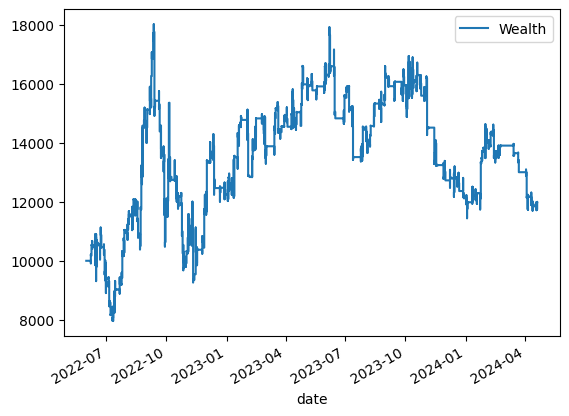

In [23]:
test_df[["Wealth"]].plot()

In [28]:
rt=((1.06770/1.07388 - 1)*-10) +1
10_000*rt

10575.4832942228

In [33]:
9972.509342*(1-0.002514)

9947.43845351421

In [31]:
bt.loc[(bt.close_time>='2022-06-08 14:01:00') & (bt.close_time<="2022-06-08 16:00")].head(20)

,close_time,Close,8-14-return,signal,position,return,net_position_change,portfolio_change,Wealth,fees
date,,,,,,,,,,
2022-06-08,2022-06-08 14:01:00+00:00,1.07366,0.004997,0.0,0.0,0.003646,0.0,0.000000,10000.000000,0.0
2022-06-08,2022-06-08 14:02:00+00:00,1.07388,0.004997,-1.0,-10.0,0.000205,10.0,-0.002049,10000.000000,0.0
2022-06-08,2022-06-08 14:03:00+00:00,1.07415,0.004997,-1.0,-10.0,0.000251,0.0,-0.002514,9972.509342,7.0
2022-06-08,2022-06-08 14:04:00+00:00,1.07411,0.004997,-1.0,-10.0,-0.000037,0.0,0.000372,9947.435986,0.0
2022-06-08,2022-06-08 14:05:00+00:00,1.07418,0.004997,-1.0,-10.0,0.000065,0.0,-0.000652,9951.140287,0.0
2022-06-08,2022-06-08 14:06:00+00:00,1.07408,0.004997,-1.0,-10.0,-0.000093,0.0,0.000931,9944.655105,0.0
2022-06-08,2022-06-08 14:07:00+00:00,1.07452,0.004997,-1.0,-10.0,0.000410,0.0,-0.004097,9953.913009,0.0
2022-06-08,2022-06-08 14:08:00+00:00,1.07437,0.004997,-1.0,-10.0,-0.000140,0.0,0.001396,9913.136515,0.0
2022-06-08,2022-06-08 14:09:00+00:00,1.07422,0.004997,-1.0,-10.0,-0.000140,0.0,0.001396,9926.974977,0.0


In [25]:
bt.loc[bt.signal.diff()!=0]

,close_time,Close,8-14-return,signal,position,return,net_position_change,portfolio_change,Wealth,fees
date,,,,,,,,,,
2022-06-01,2022-06-01 14:01:00+00:00,1.06902,-0.001764,0.0,0.0,0.000000,NaN,0.000000,NaN,NaN
2022-06-08,2022-06-08 14:02:00+00:00,1.07388,0.004997,-1.0,-10.0,0.000205,10.0,-0.002049,10000.000000,0.0
2022-06-09,2022-06-09 14:02:00+00:00,1.06770,-0.001561,0.0,0.0,-0.000178,10.0,-0.000000,10535.708471,0.0
2022-06-10,2022-06-10 14:02:00+00:00,1.05164,-0.009741,1.0,10.0,-0.000219,10.0,-0.002187,10528.333476,0.0
2022-06-12,2022-06-12 21:05:00+00:00,1.05162,NaN,0.0,0.0,0.000057,10.0,0.000000,10485.276537,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-04-11,2024-04-11 14:02:00+00:00,1.07325,-0.001378,0.0,0.0,0.000252,10.0,0.000000,12824.680542,0.0
2024-04-12,2024-04-12 14:02:00+00:00,1.06409,-0.004156,1.0,10.0,0.000197,10.0,0.001974,12815.703266,0.0
2024-04-14,2024-04-14 21:05:00+00:00,1.06366,NaN,0.0,0.0,-0.000028,10.0,-0.000000,12781.603749,0.0


<Axes: xlabel='date'>

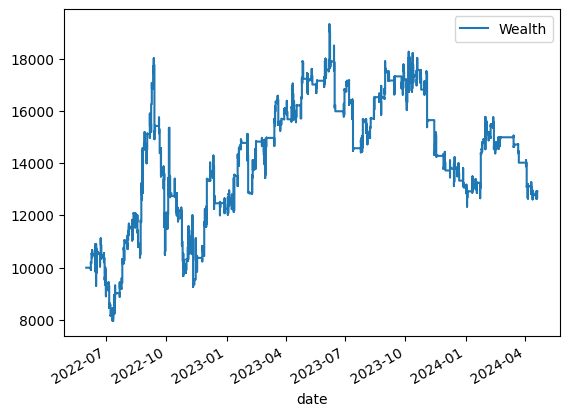

In [23]:
bt[["Wealth"]].plot()